In [129]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torch.utils.data as Data
import matplotlib.pyplot as plt
import seaborn as sns
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#导入数据
# housedata=fetch_california_housing()
#划分测试集和训练集
df_train= pd.read_csv('/kolla/ysy/all/all.csv')
x = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1).values
y = df_train['logerror'].values
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.3,random_state=42)
# from sklearn.preprocessing import StandardScaler
# #标准化处理
scale=StandardScaler()
train_x=scale.fit_transform(train_x)
test_x=scale.fit_transform(test_x)
train_x.shape,train_y.shape,test_x.shape,test_y.shape,max(train_y),min(train_y),max(test_y),min(test_y)

#array([-0.0171, -0.006 ,  0.0109, ..., -0.0171,  0.01  ,  0.0686])
#tanh  -1，1
#优化器  adam 复杂分布

((63192, 44), (63192,), (27083, 44), (27083,), 4.737, -4.605, 4.52, -4.605)

In [130]:
train_y#tanh

array([-0.0171, -0.006 ,  0.0109, ..., -0.0171,  0.01  ,  0.0686])

In [131]:
# Split dataset
def split_list_n_list(origin_list, n):
    if len(origin_list) % n == 0:
        cnt = len(origin_list) // n
    else:
        cnt = len(origin_list) // n + 1
 
    for i in range(0, n):
        yield origin_list[i*cnt:(i+1)*cnt]

In [132]:
#preparing teacher's datasets
n_teachers=10
teacher_x,teacher_y = [],[]
teacher_datasets = []
teacher_data_loader = []



teacher_x_loder = split_list_n_list(train_x,n_teachers)
teacher_y_loder = split_list_n_list(train_y,n_teachers)

teacher_x.extend(iter(teacher_x_loder))
teacher_y.extend(iter(teacher_y_loder))

for i in range(n_teachers):
    print(i,teacher_x[i].shape,teacher_y[i].shape)


from torch.utils.data import TensorDataset, DataLoader
teacher_datasets.extend(TensorDataset(torch.tensor(teacher_x[u],device=device,dtype=torch.float),
                                       torch.tensor(teacher_y[u],device=device,dtype=torch.float))
                        for u in  range(n_teachers))

teacher_data_loader.extend(DataLoader(teacher_datasets[i],batch_size=32,shuffle=True)
                           for i in range(n_teachers))


print('for stu')

#preparing student's dataset
student_x,student_y = [] ,[]
student_datasets= []
 

student_x_loder =  split_list_n_list(test_x,2)
student_y_loder =  split_list_n_list(test_y,2)
student_x.extend(iter(student_x_loder))
student_y.extend(iter(student_y_loder))

for i in range(2):
    print(i,student_x[i].shape,student_y[i].shape)

student_datasets.extend(
                        TensorDataset(torch.tensor(student_x[u],device=device,dtype=torch.float),
                                      torch.tensor(student_y[u],device=device,dtype=torch.float))
                        for u in range(2)
)

student_train_loader = DataLoader(student_datasets[0], batch_size=len(student_datasets[0]),shuffle=True)
student_test_loader = DataLoader(student_datasets[1], batch_size=len(student_datasets[1]))



0 (6320, 44) (6320,)
1 (6320, 44) (6320,)
2 (6320, 44) (6320,)
3 (6320, 44) (6320,)
4 (6320, 44) (6320,)
5 (6320, 44) (6320,)
6 (6320, 44) (6320,)
7 (6320, 44) (6320,)
8 (6320, 44) (6320,)
9 (6312, 44) (6312,)
for stu
0 (13542, 44) (13542,)
1 (13541, 44) (13541,)


In [133]:
# neural network model mlp
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = nn.Sequential(nn.Linear(in_features=44, out_features=880, bias=True),
                                  nn.Dropout(0.3),
                                  nn.Tanh()
                                  )
        
        self.hidden2 = nn.Sequential(nn.Linear(in_features=880, out_features=220, bias=True),
                                  nn.Dropout(0.3),
                                  nn.Tanh()
                                  )
        
        self.hidden3 = nn.Sequential(nn.Linear(in_features=220, out_features=44, bias=True),
                                  nn.Dropout(0.3),
                                  nn.Tanh()
                                  )
        
        self.predict = nn.Sequential(nn.Linear(in_features=44, out_features=1, bias=True),
                                        nn.Tanh())
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        output = self.predict(x)
        return output[:, 0]


mlpreg=MLP().to(device)
print(mlpreg)

MLP(
  (hidden1): Sequential(
    (0): Linear(in_features=44, out_features=880, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Tanh()
  )
  (hidden2): Sequential(
    (0): Linear(in_features=880, out_features=220, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Tanh()
  )
  (hidden3): Sequential(
    (0): Linear(in_features=220, out_features=44, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Tanh()
  )
  (predict): Sequential(
    (0): Linear(in_features=44, out_features=1, bias=True)
    (1): Tanh()
  )
)


In [134]:
 
#training configs
num_epochs=2000
batch_size =32
lr =0.001
#initializing  teachers model
teachers_model = []

for i in range(n_teachers):
    net = mlpreg
    teachers_model.append(net)
 
teacher_optimizers = [torch.optim.Adam(teachers_model[i].parameters(), lr=lr) for i in range(n_teachers)]

In [135]:
#creating teachers folders
def  mkdir_if_missing(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

for i in  range(n_teachers):
    mkdir_if_missing(f'/kolla/ysy/yzh_mlp_44/teacher{i}')

start training number 0 techer!
Number:0 epoch: 1/2000 loss_tea:0.03403651583704013
Number:0 epoch: 11/2000 loss_tea:0.025218858498537652
Number:0 epoch: 21/2000 loss_tea:0.025312670356818015
Number:0 epoch: 31/2000 loss_tea:0.024784331290122075
Number:0 epoch: 41/2000 loss_tea:0.024336029147092677
Number:0 epoch: 51/2000 loss_tea:0.02374230818587202
Number:0 epoch: 61/2000 loss_tea:0.02306614937260747
Number:0 epoch: 71/2000 loss_tea:0.02271657170303449
Number:0 epoch: 81/2000 loss_tea:0.022289623759828413
Number:0 epoch: 91/2000 loss_tea:0.02176302999988953
Number:0 epoch: 101/2000 loss_tea:0.02123252947024907
Number:0 epoch: 111/2000 loss_tea:0.021308293075689787
Number:0 epoch: 121/2000 loss_tea:0.021184747547052706
Number:0 epoch: 131/2000 loss_tea:0.02068329635253058
Number:0 epoch: 141/2000 loss_tea:0.02080125568222396
Number:0 epoch: 151/2000 loss_tea:0.0205259877044849
Number:0 epoch: 161/2000 loss_tea:0.02034368014222459
Number:0 epoch: 171/2000 loss_tea:0.019859318083883085


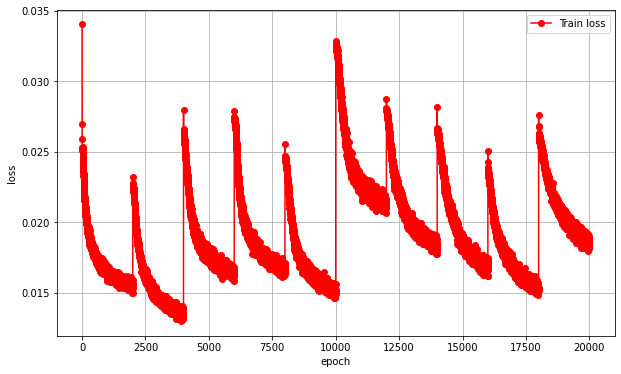

In [136]:
#training teacher models
loss_func=nn.MSELoss()
# loss_all=[[0]*num_epochs]*n_teachers
train_loss_all=[]
for tea_num in range(n_teachers):
    print(f'start training number {tea_num} techer!')
    minloss =float ('inf')
    
    for epoch in range(num_epochs):
        train_loss = 0
        train_num=0
        teachers_model[tea_num].train()
        for b_x,b_y in teacher_data_loader[tea_num]:
            teacher_optimizers[tea_num].zero_grad()
            output=teachers_model[tea_num](b_x.to(device))
            loss=loss_func(output.to(device),b_y.to(device))
            loss.backward()
            teacher_optimizers[tea_num].step()
            
            # teacher_optimizers[tea_num].zero_grad()
            # loss_houyan = teachers_model[tea_num].sample_elbo(b_x,b_y,1)
            # loss_houyan.backward()
            # teacher_optimizers[tea_num].step()

            train_loss+=loss.item() * b_x.size(0)
            train_num += b_x.size(0)
            loss_tea = train_loss/train_num
            
            if loss_tea< minloss:
                minloss = loss_tea
            # if loss_houyan< minloss:
            #     minloss = loss_houyan
                if os.path.exists(f'/kolla/ysy/yzh_mlp_44/teacher{tea_num}/best.pth'):
                    os.remove(f'/kolla/ysy/yzh_mlp_44/teacher{tea_num}/best.pth')
                torch.save(teachers_model[tea_num], f'/kolla/ysy/yzh_mlp_44/teacher{tea_num}/best.pth')
            
        
        # loss_all[tea_num][epoch]+=loss
        if epoch%10== 0:
            # print(f'Number:{tea_num}','epoch: {}/{}'.format(epoch+1,num_epochs),f'loss_tea:{loss}', f' loss_houyan:{loss_houyan}')
            print(f'Number:{tea_num}','epoch: {}/{}'.format(epoch+1,num_epochs),f'loss_tea:{loss_tea}')

        train_loss_all.append(loss_tea)
    print(f'finished training number {tea_num} techer!')
    
  
plt.figure(figsize=(10,6))
plt.plot(train_loss_all,"ro-",label="Train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()          
            

In [137]:
# #confidence interval 
# #获取样本和标签之间的置信区间关系 找到上下界  判断样本是否在区间内 在阈值内 即打上标签
# samples = 13542
# y_samp = np.zeros((samples,1))
# for s in range(samples):
#     for b_x,b_y  in student_train_loader:
#         y = net (b_x[s]).cpu().detach().numpy()
#         y_samp[s] = y.reshape(-1)
# # print(y_samp)
# lower = np.percentile(y_samp, 2.5, axis = 0)
# upper = np.percentile(y_samp, 97.5, axis = 0)
# print(f'lower:{lower},upper:{upper}')
# #97.5-2.5////99-2
# # 真实：tensor(-2.3130, device='cuda:0') tensor(4.5200, device='cuda:0')


In [138]:
# print(lower,upper)
# count = 0 
# for i in range(13542):
#     for b_x,b_y in student_train_loader:
#     #     print(max(b_y),min(b_y)) tensor(5.0000) tensor(0.1500)
#     #     print(b_y)
#         if lower<=b_y[i].item()<=upper:
#             count+=1
# print (count,count/13542,13542-count)
# #其实只丢了134条数据

In [139]:
# # for b_x,b_y in student_train_loader:
# #     print(b_y[0].item())
# #     b_y[0]=1
# #     print(b_y[0])
# upper=torch.tensor(upper).to(device)
# lower= torch.tensor(lower).to(device)
# print(lower)
# print(upper)

In [140]:
#teahcer labeling
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# teacher_best_models =[torch.load(f'/kolla/ysy/yzh_mlp_44/teacher{tea_num}/best.pth')  for  tea in  range(n_teachers)]
# fz1 =torch.zeros(13542,1).to(device)

# for tea in range(n_teachers):
#     for x,y in student_train_loader:
#         teacher_best_models[tea].eval().to(device)
#         fz=teacher_best_models[tea].forward(x)
#         fz1=(fz1+fz)              
#     fz1=(fz1+fz)
# fz1 = fz1/n_teachers
# # return fz1
# # print(fz1[2063].item())
# print(fz1)
# # old = 0
# for i in range(13542):
#     for x,y in student_train_loader:
# #         if fz1[i].item()>upper or fz1[i].item()<lower:
#         fz1[i]= torch.where(fz1[i]>upper,y[i],fz1[i])
#         fz1[i]= torch.where(fz1[i]<lower,y[i],fz1[i])        
# print(fz1)

#teahcer labeling
teacher_best_models =[torch.load(f'/kolla/ysy/yzh_mlp_44/teacher{tea_num}/best.pth')  for  tea_num in  range(n_teachers)]
# teacher_best_models =[torch.load(f'/kolla/ysy/yzh_mlp_44/teacher{tea_num}/best.pth')  for  tea in  range(n_teachers)]

fz1 =torch.zeros(13542,).to(device)
# print(fz1)
# fz2 =torch.ones(2,3).cuda()
fz =float()
for tea in range(n_teachers):
    for x ,y in student_train_loader:
        teacher_best_models[tea].eval().to(device)
        
        fz = teacher_best_models[tea](x)
        # print(fz)
    fz1=(fz1+fz)
    
fz1 = fz1/n_teachers
# fz1=fz1/10
print(fz1)


tensor([-0.0852, -0.0655, -0.0792,  ..., -0.1021, -0.0553, -0.0637],
       device='cuda:0', grad_fn=<DivBackward0>)


In [141]:
#student_label
student_trainset =TensorDataset(torch.tensor(student_x[0],device=device,dtype=torch.float),torch.tensor(fz1,device=device,dtype=torch.float))
student_train_loader1 = DataLoader(student_trainset,batch_size=batch_size)
#initialzing student model
student_model=mlpreg
student_optimizer = torch.optim.Adam(student_model.parameters(), lr=0.001) 

/home/ysy/anaconda3/envs/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [142]:
#creating student  folders
def  mkdir_if_missing(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

mkdir_if_missing(f'/kolla/ysy/yzh_mlp_44/stu')

In [143]:
#train student model
loss_func=nn.MSELoss()
print('start training')
minloss=float('inf')
for epoch in  range(1000):
    train_loss = 0
    train_num=0
    student_model.train()
    for b_x,b_y in  student_train_loader1:
        student_optimizer.zero_grad()
        output=student_model(b_x.to(device))
        loss=loss_func(output.to(device),b_y.to(device))
        loss.backward()
        student_optimizer.step()
        train_loss+=loss.item() * b_x.size(0)
        train_num += b_x.size(0)
        loss_stu = train_loss/train_num
        if loss_stu < minloss:
            minloss = loss_stu
            if os.path.exists(f'/kolla/ysy/yzh1/stu/best.pth'):
                os.remove(f'/kolla/ysy/yzh1/stu/best.pth')
            torch.save(student_model, f'/kolla/ysy/yzh1/stu/best.pth')
    if epoch%10 == 0:
        print(f'student train: Epo:{epoch}  Loss_stu:{loss_stu}')
        

start training
student train: Epo:0  Loss_stu:0.007079924354750596
student train: Epo:10  Loss_stu:0.0016463402068251233
student train: Epo:20  Loss_stu:0.0016553837267769711
student train: Epo:30  Loss_stu:0.0016514421878400444
student train: Epo:40  Loss_stu:0.0016349594777851873
student train: Epo:50  Loss_stu:0.0016464705448245552
student train: Epo:60  Loss_stu:0.001645094183839752
student train: Epo:70  Loss_stu:0.0016374703249335647
student train: Epo:80  Loss_stu:0.0016428449740321827
student train: Epo:90  Loss_stu:0.001639103319007904
student train: Epo:100  Loss_stu:0.0016512655220615505
student train: Epo:110  Loss_stu:0.0016484634761356467
student train: Epo:120  Loss_stu:0.0016361898204210357
student train: Epo:130  Loss_stu:0.0016414536272869253
student train: Epo:140  Loss_stu:0.0016403905917449398
student train: Epo:150  Loss_stu:0.0016276962618976105
student train: Epo:160  Loss_stu:0.0016344394070953088
student train: Epo:170  Loss_stu:0.0016336031336679267
student t

In [144]:
#eval  student model
student_best_model =torch.load('/kolla/ysy/yzh1/stu/best.pth')

# for x,y in  student_test_loader:
#     student_best_model.eval().to(device)
#     sy=student_best_model(x)


# sy.shape
# print(sy)


for s_x,s_y in  student_test_loader:
    student_best_model.eval().to(device)
    pred=student_best_model(s_x)
 

# sy.shape
    loss_test=loss_func(pred,s_y) 
print(f'student test Loss:{loss_test}',f'\n predict:{pred}',f'\n b_y:{s_y}')
# array = y.cpu().numpy()

# print(len(s_x))
#找到置信区间 若在student_test_loader中的x的置信度符合该置信区间的 我就加入到新的测试集中，并加入对应标签。训练取loss
# 给各个地方打上标签，对不熟的标签 进行剔除投票 将原有数据集的y标签进行聚合

student test Loss:0.030303455889225006 
 predict:tensor([-0.0483, -0.0749, -0.0787,  ..., -0.0559, -0.0640, -0.0380],
       device='cuda:0', grad_fn=<SelectBackward>) 
 b_y:tensor([-0.8675, -0.0182,  0.4787,  ...,  0.0469,  0.5218,  0.0392],
       device='cuda:0')
